In [ ]:
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


import matplotlib
import pickle

In [ ]:
selections = pd.read_csv("./data/selections.csv")
impressions = pd.read_csv("./data/impressions.csv")

In [ ]:
impressions

In [ ]:
ft_no_ft = pd.read_csv("./data/ft_no_ft_comparison.csv")
ft_no_ft_impressions = pd.read_csv("./data/ft_no_ft_recommendations.csv")
ft_impressions = ft_no_ft_impressions[ft_no_ft_impressions.kind == "ft"]
beta_ft_impressions = ft_no_ft_impressions[ft_no_ft_impressions.kind == "beta_ft"]

imp1 = impressions[impressions.mo == False].set_index(["userId", "movieId", "session"])
imp3 = beta_ft_impressions.set_index(["userId", "movieId", "session"])
s1 = selections[selections.mo == False].set_index(["userId", "movieId", "session"])
beta_ft_selections = s1.loc[imp3.index.intersection(s1.index)]

In [178]:
# Objectives / metrics
import functools
from sklearn.preprocessing import MultiLabelBinarizer, QuantileTransformer, label_binarize

PATH_TO_ML_DATASET_MOVIES_DF = None
assert PATH_TO_ML_DATASET_MOVIES_DF is not None, "Please set proper PATH_TO_ML_DATASET_MOVIES_DF"

rating_matrix = np.load("./data/rating_matrix_backup.npy")
movies_info_df = pd.read_csv(PATH_TO_ML_DATASET_MOVIES_DF)
movies_info_df.year = movies_info_df.year.astype(int)
movies_info_df = movies_info_df.set_index("movieId")

similarity_matrix = np.load("./data/similarity_matrix_backup.npy")
distance_matrix = 1.0 - similarity_matrix
ratings = pd.read_csv("./data/ratings.csv")
indexedRatings = ratings.set_index(["userId", "session","movieId"])

@functools.cache
def get_all_genres():
    all_genres = set()
    for row in movies_info_df.genres.unique():
        genres = row.split("|")
        all_genres = all_genres.union(genres)
    return all_genres

# !!!!!!!!!!!!
# Multigenre means that multiple genres assigned to a single movie are treated as a single genre

@functools.cache
def get_all_multi_genres():
    return movies_info_df.genres.unique()

year_cdf = QuantileTransformer().fit(movies_info_df.year.values.reshape(-1, 1))
binarizer = MultiLabelBinarizer(classes=list(get_all_genres()))
binarizer = binarizer.fit(None)

# Recall@K
# Rec_list is the list with recommendations
# All user selections are user selections
def recall(rec_list, all_user_selections):
    rec_list_correct = [x for x in rec_list if x in all_user_selections]
    if min(len(all_user_selections), len(rec_list)) == 0:
        return 0.0
    return len(rec_list_correct) / min(len(all_user_selections), len(rec_list))

# Return all genres that given movie has
def get_item_genres(item_index):
    item_id = movie_index_to_id[item_index]
    genres = movies_info_df.loc[item_id].genres.split("|")
    return genres

def get_item_multi_genres(item_index):
    item_id = movie_index_to_id[item_index]
    return movies_info_df.loc[item_id].genres

# Return all genres that all movies in the recommendation list have altogether (union over their genres)
def get_list_genres(rec_list, get_item_genres_f):
    all_genres = set()
    for item in rec_list:
        all_genres = all_genres.union(get_item_genres_f(item))
    return all_genres

def topic_coverage(rec_list, get_item_genres_f, get_all_genres_f):
    rec_list_genres = get_list_genres(rec_list, get_item_genres_f)

    return len(rec_list_genres) / len(get_all_genres_f())

def collaborative_diversity(item_a, item_b):
    if item_b is None:
        return distance_matrix[item_a].sum() / (distance_matrix.shape[0] - 1)
    return distance_matrix[item_a, item_b]

def content_based_diversity(item_a, item_b):
    if item_b is None:
        return 0.0
    #inpt = [list(get_item_genres(item_a)), list(get_item_genres(item_b))]
    #res = binarizer.fit_transform(inpt)
    res = binarizer.transform([get_item_genres(item_a), get_item_genres(item_b)])
    cos_sim = (cosine_similarity(res[0], res[1]) + 1) / 2 # Convert from [-1, 1] to [0, 1]
    return 1 - cos_sim # Convert to distance


def content_based_diversity_multigenre(item_a, item_b):
    res = label_binarize([get_item_multi_genres(item_a), get_item_multi_genres(item_b)], classes=get_all_multi_genres())
    cos_sim = (cosine_similarity(res[0], res[1]) + 1) / 2 # Convert from [-1, 1] to [0, 1]
    return 1 - cos_sim # Convert to distance

def inverse_popularity(item):
    return (-1 * (np.sum(rating_matrix > 0.0, axis=0) / rating_matrix.shape[0])[item]).mean()
    
def get_item_year(item):
    item_id = movie_index_to_id[item]
    return movies_info_df.loc[item_id].year
    
def temporal_novelty(items):
    x = [year_cdf.transform([[get_item_year(item)]]).squeeze() for item in items]
    return sum(x) / len(x)
    
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))
    
def intra_list_diversity(rec_list, div_func):
    assert len(rec_list) > 0
    n = len(rec_list)
    div = 0
    
    if n == 1:
        return div_func(rec_list[0], None) # Overload to calculate mean diversity of an item
    
    for i in range(n):
        for j in range(i):
            div += div_func(rec_list[i], rec_list[j])
    return div / ((n - 1) * n / 2)

def get_mean_relevance(rec_list, user, session):
    idx = list(zip([user]*len(rec_list),[session]*len(rec_list),rec_list))
    idxValidity = [i in indexedRatings.index for i in idx]
    idx = np.array(idx)[idxValidity].tolist()
    
    return indexedRatings.loc[idx,"rawRating"].mean()

def mean_relevance_per_session(rec_list, userId, session):
    return np.array([ratings_indexed.loc[(userId, session, item)].rawRating for item in rec_list]).mean()

def list_novelty(rec_list, nov_func):
    assert len(rec_list) > 0
    
    n = len(rec_list)
    nov = 0    
    for i in range(n):
        nov += nov_func(rec_list[i])
    return nov / n

In [ ]:
with open("./data/movie_index_to_id.pckl", "rb") as f:
    movie_index_to_id = pickle.load(f)

In [ ]:
# Final result generation
obj_comparison = pd.DataFrame(columns=["userId", "value", "objective", "kind"])

# Selections Coverage
dv = beta_ft_selections.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "Coverage"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "Coverage"
dv.loc[:, "source"] = "selections"
dv = dv.rename(columns={"Coverage": "value"})

dv2 = s1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "Coverage"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "Coverage"
dv2.loc[:, "source"] = "selections"
dv2 = dv2.rename(columns={"Coverage": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Impressions Coverage
dv = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "Coverage"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "Coverage"
dv.loc[:, "source"] = "impressions"
dv = dv.rename(columns={"Coverage": "value"})

dv2 = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "Coverage"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "Coverage"
dv2.loc[:, "source"] = "impressions"
dv2 = dv2.rename(columns={"Coverage": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])

# Selections ILD
dv = beta_ft_selections.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "ILD"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "ILD"
dv.loc[:, "source"] = "selections"
dv = dv.rename(columns={"ILD": "value"})

dv2 = s1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "ILD"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "ILD"
dv2.loc[:, "source"] = "selections"
dv2 = dv2.rename(columns={"ILD": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Impressions ILD
dv = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "ILD"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "ILD"
dv.loc[:, "source"] = "impressions"
dv = dv.rename(columns={"ILD": "value"})

dv2 = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "ILD"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "ILD"
dv2.loc[:, "source"] = "impressions"
dv2 = dv2.rename(columns={"ILD": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Selections CB-ILD
dv = beta_ft_selections.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "CB-ILD"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "CB-ILD"
dv.loc[:, "source"] = "selections"
dv = dv.rename(columns={"CB-ILD": "value"})

dv2 = s1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "CB-ILD"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "CB-ILD"
dv2.loc[:, "source"] = "selections"
dv2 = dv2.rename(columns={"CB-ILD": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Impressions CB-ILD
dv = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "CB-ILD"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "CB-ILD"
dv.loc[:, "source"] = "impressions"
dv = dv.rename(columns={"CB-ILD": "value"})

dv2 = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "CB-ILD"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "CB-ILD"
dv2.loc[:, "source"] = "impressions"
dv2 = dv2.rename(columns={"CB-ILD": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Selections Novelty
dv = beta_ft_selections.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "novelty"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "novelty"
dv.loc[:, "source"] = "selections"
dv = dv.rename(columns={"novelty": "value"})

dv2 = s1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "novelty"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "novelty"
dv2.loc[:, "source"] = "selections"
dv2 = dv2.rename(columns={"novelty": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Impressions Novelty
dv = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "novelty"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "novelty"
dv.loc[:, "source"] = "impressions"
dv = dv.rename(columns={"novelty": "value"})

dv2 = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "novelty"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "novelty"
dv2.loc[:, "source"] = "impressions"
dv2 = dv2.rename(columns={"novelty": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Selections temporal novelty
dv = beta_ft_selections.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "TemporalNovelty"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "TemporalNovelty"
dv.loc[:, "source"] = "selections"
dv = dv.rename(columns={"TemporalNovelty": "value"})

dv2 = s1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "TemporalNovelty"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "TemporalNovelty"
dv2.loc[:, "source"] = "selections"
dv2 = dv2.rename(columns={"TemporalNovelty": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Impressions Temporal Novelty
dv = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "TemporalNovelty"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "TemporalNovelty"
dv.loc[:, "source"] = "impressions"
dv = dv.rename(columns={"TemporalNovelty": "value"})

dv2 = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .reset_index().groupby("session").mean().rename(columns={"movieId": "TemporalNovelty"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "TemporalNovelty"
dv2.loc[:, "source"] = "impressions"
dv2 = dv2.rename(columns={"TemporalNovelty": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])

#sns.displot(data=pd.concat([dv, dv2]), x="Coverage", hue="kind", kind="kde")
#plt.savefig("ft_no_ft_selections_cluster_not_per_session.pdf")

#### For selections

In [ ]:

# Selections Coverage
dv = beta_ft_selections.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .rename(columns={"movieId": "Coverage"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "Coverage"
dv.loc[:, "source"] = "selections_overall"
dv = dv.rename(columns={"Coverage": "value"})

dv2 = s1.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .rename(columns={"movieId": "Coverage"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "Coverage"
dv2.loc[:, "source"] = "selections_overall"
dv2 = dv2.rename(columns={"Coverage": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])

# Selections ILD
dv = beta_ft_selections.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .rename(columns={"movieId": "ILD"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "ILD"
dv.loc[:, "source"] = "selections_overall"
dv = dv.rename(columns={"ILD": "value"})

dv2 = s1.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .rename(columns={"movieId": "ILD"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "ILD"
dv2.loc[:, "source"] = "selections_overall"
dv2 = dv2.rename(columns={"ILD": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])

# Selections CB-ILD
dv = beta_ft_selections.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .rename(columns={"movieId": "CB-ILD"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "CB-ILD"
dv.loc[:, "source"] = "selections_overall"
dv = dv.rename(columns={"CB-ILD": "value"})

dv2 = s1.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .rename(columns={"movieId": "CB-ILD"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "CB-ILD"
dv2.loc[:, "source"] = "selections_overall"
dv2 = dv2.rename(columns={"CB-ILD": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])


# Selections Novelty
dv = beta_ft_selections.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .rename(columns={"movieId": "novelty"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "novelty"
dv.loc[:, "source"] = "selections_overall"
dv = dv.rename(columns={"novelty": "value"})

dv2 = s1.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .rename(columns={"movieId": "novelty"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "novelty"
dv2.loc[:, "source"] = "selections_overall"
dv2 = dv2.rename(columns={"novelty": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])

# Selections temporal novelty, not per session
dv = beta_ft_selections.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .rename(columns={"movieId": "TemporalNovelty"}).reset_index()
dv.loc[:, "kind"] = "beta_ft"
dv.loc[:, "objective"] = "TemporalNovelty"
dv.loc[:, "source"] = "selections_overall"
dv = dv.rename(columns={"TemporalNovelty": "value"})

dv2 = s1.reset_index().groupby(["userId"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .rename(columns={"movieId": "TemporalNovelty"}).reset_index()
dv2.loc[:, "kind"] = "ft"
dv2.loc[:, "objective"] = "TemporalNovelty"
dv2.loc[:, "source"] = "selections_overall"
dv2 = dv2.rename(columns={"TemporalNovelty": "value"})

obj_comparison = pd.concat([obj_comparison, dv2, dv])

In [ ]:
def increase_font_size(scale=1.5):
    font_keys = ["axes.labelsize", "axes.titlesize", "legend.fontsize",
             "xtick.labelsize", "ytick.labelsize", "font.size"]
    font_dict = {k: matplotlib.rcParams[k] * scale if k == "font.size" else "x-large" for k in font_keys}
    matplotlib.rcParams.update(font_dict)

In [ ]:
sns.reset_defaults()
increase_font_size(1.5)

In [ ]:
# Filter results
def f_r(objective, kind, source):
    return obj_comparison[(obj_comparison.objective == objective) & (obj_comparison.kind == kind) & (obj_comparison.source == source)].value

def map_obj_name(x):
    if x == "novelty":
        return "Novelty"
    elif x == "TemporalNovelty":
        return "Temporal Novelty"
    elif x == "ILD":
        return "CL-ILD"
    else:
        return x

#g = sns.JointGrid(x="value", data=obj_comparison, height=3)
#axs = plt.subplots(1, 4)
obj_comparison.objective = obj_comparison.objective.map(lambda x: map_obj_name(x))
g = sns.FacetGrid(data=obj_comparison[obj_comparison.objective != "Coverage"], col="objective", legend_out=True, height=3, sharey=False, sharex=False)

#g.set_titles(col_template="{col_name}")
g.set_titles(col_template="")

g.fig.set_figwidth(4.5 * 5)

g.fig.subplots_adjust(hspace=0.125, wspace=0.140)


g2 = sns.kdeplot(
    x=f_r("CL-ILD", "ft", "impressions"),
    fill=True, ax=g.axes[0, 0], common_norm=True
)
g2.set(xlim=(0.7, 1.0))

g2 = sns.kdeplot(
    x=f_r("CL-ILD", "beta_ft", "impressions"),
    fill=True, ax=g.axes[0, 0], common_norm=True #g.ax_joint
)
g2.set(xlim=(0.7, 1.0))

g2 = sns.kdeplot(
    x=f_r("CL-ILD", "ft", "selections_overall"),
    fill=False, ax=g.axes[0, 0], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(0.7, 1.0))

g2 = sns.kdeplot(
    x=f_r("CL-ILD", "beta_ft", "selections_overall"),
    fill=False, ax=g.axes[0, 0], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(0.7, 1.0))


g2 = sns.kdeplot(
    x=f_r("CB-ILD", "ft", "impressions"),
    fill=True, ax=g.axes[0, 1], common_norm=True
)
g2.set(xlim=(0.1, 0.5))

g2 = sns.kdeplot(
    x=f_r("CB-ILD", "beta_ft", "impressions"),
    fill=True, ax=g.axes[0, 1], common_norm=True #g.ax_joint
)
g2.set(xlim=(0.1, 0.5))

g2 = sns.kdeplot(
    x=f_r("CB-ILD", "ft", "selections_overall"),
    fill=False, ax=g.axes[0, 1], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(0.1, 0.5))

g2 = sns.kdeplot(
    x=f_r("CB-ILD", "beta_ft", "selections_overall"),
    fill=False, ax=g.axes[0, 1], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(0.1, 0.5))



g2 = sns.kdeplot(
    x=f_r("Novelty", "ft", "impressions"),
    fill=True, ax=g.axes[0, 2], common_norm=True
)
g2.set(xlim=(-0.05, 0.01))

g2 = sns.kdeplot(
    x=f_r("Novelty", "beta_ft", "impressions"),
    fill=True, ax=g.axes[0, 2], common_norm=True #g.ax_joint
)
g2.set(xlim=(-0.05, 0.01))

g2 = sns.kdeplot(
    x=f_r("Novelty", "ft", "selections_overall"),
    fill=False, ax=g.axes[0, 2], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(-0.05, 0.01))

g2 = sns.kdeplot(
    x=f_r("Novelty", "beta_ft", "selections_overall"),
    fill=False, ax=g.axes[0, 2], linestyle="--", linewidth=2.5, common_norm=True
)
g2.set(xlim=(-0.05, 0.01))



g2 = sns.kdeplot(
    x=f_r("Temporal Novelty", "ft", "impressions"),
    fill=True, ax=g.axes[0, 3], common_norm=True,
    label="Beta Impressions"
)
g2.set(xlim=(0.5, 0.75))
g2 = sns.kdeplot(
    x=f_r("Temporal Novelty", "beta_ft", "impressions"),
    fill=True, ax=g.axes[0, 3], common_norm=True, #g.ax_joint
    label="SOT-Beta Impressions"
)
g2.set(xlim=(0.5, 0.75))

g2 = sns.kdeplot(
    x=f_r("Temporal Novelty", "ft", "selections_overall"),
    fill=False, ax=g.axes[0, 3], linestyle="--", linewidth=2.5, common_norm=False,
    label="Beta Selections"
)
g2.set(xlim=(0.5, 0.75))

g2 = sns.kdeplot(
    x=f_r("Temporal Novelty", "beta_ft", "selections_overall"),
    fill=False, ax=g.axes[0, 3], linestyle="--", linewidth=2.5, common_norm=False,
    label="SOT-Beta Selections"
)
g2.set(xlim=(0.5, 0.75))


g.axes[0,1].set_ylabel('')
g.axes[0,2].set_ylabel('')
g.axes[0,3].set_ylabel('')

g.axes[0,0].set_xlabel('CL-ILD')
g.axes[0,1].set_xlabel('CB-ILD')
g.axes[0,2].set_xlabel('Novelty')
g.axes[0,3].set_xlabel('Temporal Novelty')

g.axes[0][3].legend(loc='lower center', bbox_to_anchor=(-1.25, 1.0), ncol=4, frameon=False, title=None)


plt.tight_layout()
plt.savefig("./results/ft_no_ft_obj_comparison_final.pdf", bbox_inches="tight")

In [ ]:
x = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .reset_index().rename(columns={"movieId": "ILD"}).reset_index().ILD.values

y = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)}) \
    .reset_index().rename(columns={"movieId": "ILD"}).reset_index().ILD.values

ttest_ind(y, x, alternative="greater")

In [ ]:
f_r("CL-ILD", "beta_ft", "selections_overall").mean()

In [ ]:
f_r("CL-ILD", "ft", "selections_overall").mean()

In [ ]:
f_r("CL-ILD", "ft", "selections_overall")

In [ ]:
ttest_ind(f_r("CL-ILD", "ft", "selections_overall"), f_r("CL-ILD", "beta_ft", "selections_overall"), alternative="greater")

In [ ]:
x = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .reset_index().rename(columns={"movieId": "ILD"}).reset_index().ILD.values

y = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)}) \
    .reset_index().rename(columns={"movieId": "ILD"}).reset_index().ILD.values

ttest_ind(y, x, alternative="greater")

In [ ]:
f_r("CB-ILD", "ft", "impressions").mean()

In [ ]:
f_r("CB-ILD", "beta_ft", "impressions").mean()

In [ ]:
f_r("CB-ILD", "ft", "selections_overall").mean()

In [ ]:
f_r("CB-ILD", "beta_ft", "selections_overall").mean()

In [ ]:
f_r("CB-ILD", "beta_ft", "selections_overall")

In [ ]:
ttest_ind(f_r("Temporal Novelty", "ft", "selections_overall"), f_r("Temporal Novelty", "beta_ft", "selections_overall"))

In [ ]:
f_r("Coverage", "beta_ft", "impressions").mean()

In [ ]:
f_r("Coverage", "ft", "impressions").mean()

In [ ]:
x = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .reset_index().rename(columns={"movieId": "Coverage"}).reset_index().Coverage.values

y = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)}) \
    .reset_index().rename(columns={"movieId": "Coverage"}).reset_index().Coverage.values

ttest_ind(y, x, alternative="greater")

In [ ]:
f_r("Coverage", "beta_ft", "selections_overall").mean()

In [ ]:
f_r("Coverage", "ft", "selections_overall").mean()

In [ ]:
ttest_ind(f_r("Coverage", "ft", "selections_overall"), f_r("Coverage", "beta_ft", "selections_overall"), alternative="greater")

In [ ]:
x = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .reset_index().rename(columns={"movieId": "Novelty"}).reset_index().Novelty.values

y = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())}) \
    .reset_index().rename(columns={"movieId": "Novelty"}).reset_index().Novelty.values

ttest_ind(y, x, alternative="greater")

In [ ]:
f_r("Novelty", "ft", "impressions").mean()

In [ ]:
f_r("Novelty", "beta_ft", "impressions").mean()

In [ ]:
x = beta_ft_impressions.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .reset_index().rename(columns={"movieId": "Temporal Novelty"}).reset_index()["Temporal Novelty"].values

y = imp1.reset_index().groupby(["userId", "session"]) \
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())}) \
    .reset_index().rename(columns={"movieId": "Temporal Novelty"}).reset_index()["Temporal Novelty"].values

ttest_ind(y, x, alternative="greater")

In [ ]:
f_r("Temporal Novelty", "ft", "impressions").mean()

In [ ]:
f_r("Temporal Novelty", "beta_ft", "impressions").mean()

## Per algo objectives on impressions

In [ ]:
x = impressions.groupby(["userId", "session", "realAlgo"])\
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)})\
    .rename(columns={"movieId": "ILD"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].ILD, x[x.realAlgo == "GAMMA"].ILD))
print(ttest_ind(x[x.realAlgo == "BETA"].ILD, x[x.realAlgo == "DELTA"].ILD))
print(ttest_ind(x[x.realAlgo == "DELTA"].ILD, x[x.realAlgo == "GAMMA"].ILD))

x.groupby("realAlgo").mean()

In [ ]:
x = impressions.groupby(["userId", "session", "realAlgo"])\
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)})\
    .rename(columns={"movieId": "CB-ILD"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"]["CB-ILD"], x[x.realAlgo == "GAMMA"]["CB-ILD"]))
print(ttest_ind(x[x.realAlgo == "BETA"]["CB-ILD"], x[x.realAlgo == "DELTA"]["CB-ILD"]))
print(ttest_ind(x[x.realAlgo == "DELTA"]["CB-ILD"], x[x.realAlgo == "GAMMA"]["CB-ILD"]))

x.groupby("realAlgo").mean()

In [ ]:
x = impressions.groupby(["userId", "session", "realAlgo"])\
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)})\
    .rename(columns={"movieId": "Coverage"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].Coverage, x[x.realAlgo == "GAMMA"].Coverage))
print(ttest_ind(x[x.realAlgo == "BETA"].Coverage, x[x.realAlgo == "DELTA"].Coverage))
print(ttest_ind(x[x.realAlgo == "DELTA"].Coverage, x[x.realAlgo == "GAMMA"].Coverage))

x.groupby("realAlgo").mean()

In [ ]:
x = impressions.groupby(["userId", "session", "realAlgo"])\
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())})\
    .rename(columns={"movieId": "Novelty"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].Novelty, x[x.realAlgo == "GAMMA"].Novelty))
print(ttest_ind(x[x.realAlgo == "BETA"].Novelty, x[x.realAlgo == "DELTA"].Novelty))
print(ttest_ind(x[x.realAlgo == "DELTA"].Novelty, x[x.realAlgo == "GAMMA"].Novelty))

x.groupby("realAlgo").mean()

In [ ]:
x = impressions.groupby(["userId", "session", "realAlgo"])\
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())})\
    .rename(columns={"movieId": "Temporal Novelty"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"]["Temporal Novelty"], x[x.realAlgo == "GAMMA"]["Temporal Novelty"]))
print(ttest_ind(x[x.realAlgo == "BETA"]["Temporal Novelty"], x[x.realAlgo == "DELTA"]["Temporal Novelty"]))
print(ttest_ind(x[x.realAlgo == "DELTA"]["Temporal Novelty"], x[x.realAlgo == "GAMMA"]["Temporal Novelty"]))

x.groupby("realAlgo").mean()

## Per algo objectives on selections

In [ ]:
x = selections.groupby(["userId", "realAlgo"])\
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), collaborative_diversity)})\
    .rename(columns={"movieId": "ILD"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].ILD, x[x.realAlgo == "GAMMA"].ILD))
print(ttest_ind(x[x.realAlgo == "BETA"].ILD, x[x.realAlgo == "DELTA"].ILD))
print(ttest_ind(x[x.realAlgo == "DELTA"].ILD, x[x.realAlgo == "GAMMA"].ILD))

x.groupby("realAlgo").mean()

In [ ]:
x = selections.groupby(["userId", "realAlgo"])\
    .agg({"movieId": lambda x: intra_list_diversity(x.astype(int).tolist(), content_based_diversity)})\
    .rename(columns={"movieId": "CB-ILD"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"]["CB-ILD"], x[x.realAlgo == "GAMMA"]["CB-ILD"]))
print(ttest_ind(x[x.realAlgo == "BETA"]["CB-ILD"], x[x.realAlgo == "DELTA"]["CB-ILD"]))
print(ttest_ind(x[x.realAlgo == "DELTA"]["CB-ILD"], x[x.realAlgo == "GAMMA"]["CB-ILD"]))

x.groupby("realAlgo").mean()

In [ ]:
x = selections.groupby(["userId", "realAlgo"])\
    .agg({"movieId": lambda x: topic_coverage(x.astype(int).tolist(), get_item_genres, get_all_genres)})\
    .rename(columns={"movieId": "Coverage"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].Coverage, x[x.realAlgo == "GAMMA"].Coverage))
print(ttest_ind(x[x.realAlgo == "BETA"].Coverage, x[x.realAlgo == "DELTA"].Coverage))
print(ttest_ind(x[x.realAlgo == "DELTA"].Coverage, x[x.realAlgo == "GAMMA"].Coverage))

x.groupby("realAlgo").mean()

In [ ]:
x = selections.groupby(["userId", "realAlgo"])\
    .agg({"movieId": lambda x: inverse_popularity(x.astype(int).tolist())})\
    .rename(columns={"movieId": "Novelty"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"].Novelty, x[x.realAlgo == "GAMMA"].Novelty))
print(ttest_ind(x[x.realAlgo == "BETA"].Novelty, x[x.realAlgo == "DELTA"].Novelty))
print(ttest_ind(x[x.realAlgo == "DELTA"].Novelty, x[x.realAlgo == "GAMMA"].Novelty))

x.groupby("realAlgo").mean()

In [ ]:
x = selections.groupby(["userId", "realAlgo"])\
    .agg({"movieId": lambda x: temporal_novelty(x.astype(int).tolist())})\
    .rename(columns={"movieId": "Temporal Novelty"}).reset_index()

print(ttest_ind(x[x.realAlgo == "BETA"]["Temporal Novelty"], x[x.realAlgo == "GAMMA"]["Temporal Novelty"]))
print(ttest_ind(x[x.realAlgo == "BETA"]["Temporal Novelty"], x[x.realAlgo == "DELTA"]["Temporal Novelty"]))
print(ttest_ind(x[x.realAlgo == "DELTA"]["Temporal Novelty"], x[x.realAlgo == "GAMMA"]["Temporal Novelty"]))

x.groupby("realAlgo").mean()

## Extra preprocessing

In [233]:
dfWeights = pd.read_csv("./data/weights.csv")

In [234]:
dfImpressions = impressions.copy()
dfSelections = selections.copy()

dfShownImpressions = dfImpressions

In [235]:
#all items that were (would be) shown by some algorithm in that particular session and were selected (no matter if the selection was made on that particular algorithm or not)
dfEnhancedSelections = dfImpressions.set_index(["userId","movieId","session"]).join(dfSelections.set_index(["userId","movieId","session"]), rsuffix="_selection", how="inner")

In [236]:
dfShownSelections = dfEnhancedSelections

In [ ]:
#takes couple minutes to calculate
dfShownImpressions["movieId"] = dfShownImpressions["movieId"].astype(int)

dfGroupedImpressions = dfShownImpressions.groupby(["userId","session","realAlgo"])["movieId"].apply(list).reset_index()
collDiv = []
cbDiv = []
cbDivMG = []
intNov = []
tempNov = []
for idx, row in dfGroupedImpressions.iterrows():
    collDiv.append(intra_list_diversity(row["movieId"],collaborative_diversity))
    cbDiv.append(intra_list_diversity(row["movieId"],content_based_diversity))
    cbDivMG.append(intra_list_diversity(row["movieId"],content_based_diversity_multigenre))
    intNov.append(list_novelty(row["movieId"],inverse_popularity))
    tempNov.append(temporal_novelty(row["movieId"]))
    
dfGroupedImpressions["collDiv"] = collDiv
dfGroupedImpressions["cbDiv"] = cbDiv
dfGroupedImpressions["intNov"] = intNov
dfGroupedImpressions["tempNov"] = tempNov
dfGroupedImpressions["cbDivMG"] = cbDivMG

In [179]:
relevance = []
for idx, row in dfGroupedImpressions.iterrows():
    relevance.append(get_mean_relevance(row["movieId"],row["userId"],row["session"]))   
dfGroupedImpressions["relevance"] = relevance

dfGroupedImpressions

,userId,session,realAlgo,movieId,collDiv,cbDiv,intNov,tempNov,cbDivMG,relevance
0,60,1,BETA,"[1595, 1489, 1423, 1359, 1339, 1455, 1860, 145...",0.890129,0.169690,-0.027569,0.838739,0.322222,1.548370
1,60,1,GAMMA,"[1856, 1793, 1816, 1720, 1833, 1292, 1339, 148...",0.969161,0.233497,-0.003800,0.888288,0.333333,1.390141
2,60,2,BETA,"[1756, 1702, 1434, 1726, 1573, 1494, 1428, 162...",0.914607,0.391049,-0.008679,0.900901,0.477778,2.008837
3,60,2,GAMMA,"[1701, 1756, 1703, 1769, 1616, 1633, 1555, 161...",0.998568,0.316272,-0.000848,1.000000,0.355556,1.319438
4,60,3,BETA,"[1715, 1885, 1797, 1402, 1497, 1454, 1676, 171...",0.911371,0.415268,-0.007589,0.888288,0.488889,1.976296
...,...,...,...,...,...,...,...,...,...,...
1691,185,6,DELTA,"[1827, 1713, 1553, 1790, 1610, 1617, 1768, 173...",0.994839,0.395479,-0.000705,1.000000,0.488889,0.762308
1692,185,7,BETA,"[1226, 1107, 1511, 1304, 1166, 1216, 1108, 665...",0.897384,0.348503,-0.021247,0.616216,0.477778,1.678634
1693,185,7,DELTA,"[1759, 1511, 1434, 1647, 1620, 1320, 1824, 182...",1.000000,0.373505,-0.001608,0.919369,0.488889,0.698755
1694,185,8,BETA,"[1163, 1342, 258, 1326, 1106, 1386, 1084, 679,...",0.854123,0.369580,-0.035246,0.538739,0.500000,1.579908


In [180]:
dfShownSelections = dfShownSelections.reset_index()
dfShownSelections["movieId"] = dfShownSelections["movieId"].astype(int)

In [185]:
#takes couple minutes to calculate
dfGroupedSelections = dfShownSelections.groupby(["userId","session","realAlgo"])["movieId"].apply(list).reset_index()
collDiv = []
cbDiv = []
intNov = []
tempNov = []
for idx, row in dfGroupedSelections.iterrows():
    collDiv.append(intra_list_diversity(row["movieId"],collaborative_diversity))
    cbDiv.append(intra_list_diversity(row["movieId"],content_based_diversity))
    intNov.append(list_novelty(row["movieId"],inverse_popularity))
    tempNov.append(temporal_novelty(row["movieId"]))
    
dfGroupedSelections["collDiv"] = collDiv
dfGroupedSelections["cbDiv"] = cbDiv
dfGroupedSelections["intNov"] = intNov
dfGroupedSelections["tempNov"] = tempNov

In [186]:
dfGroupedSelections["numSelected"] = list(map(len,dfGroupedSelections.movieId))
relevance = []
for idx, row in dfGroupedSelections.iterrows():
    relevance.append(get_mean_relevance(row["movieId"],row["userId"],row["session"]))   
dfGroupedSelections["relevance"] = relevance

In [193]:
dfRatings = pd.read_csv("./data/algorithm_ratings.csv")

In [221]:
dfGroupedSelectionsJoined = dfGroupedSelections.rename(columns={"realAlgo": "algorithm"}).set_index(["userId","session","algorithm"]).join(dfRatings.set_index(["userId","session","algorithm"]), how="outer")
#dfGroupedSelectionsJoined.loc[dfGroupedSelectionsJoined.isna().any(axis=1), "movieId"] = [() for x in range(dfGroupedSelectionsJoined.isna().any(axis=1).sum())]
dfGroupedSelectionsJoined = dfGroupedSelectionsJoined.fillna(0.0)

In [255]:
print(dfShownSelections.groupby("realAlgo")[["relevanceGain","diversityGain","noveltyGain"]].mean().round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
 & relevanceGain & diversityGain & noveltyGain \\
realAlgo &  &  &  \\
\midrule
BETA & 0.974000 & 0.246000 & 0.635000 \\
DELTA & 0.943000 & 0.515000 & 0.719000 \\
GAMMA & 0.910000 & 0.689000 & 0.816000 \\
\bottomrule
\end{tabular}



In [257]:
print(dfShownImpressions.groupby("realAlgo")[["relevanceGain","diversityGain","noveltyGain"]].mean().round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
 & relevanceGain & diversityGain & noveltyGain \\
realAlgo &  &  &  \\
\midrule
BETA & 0.980000 & 0.251000 & 0.653000 \\
DELTA & 0.913000 & 0.659000 & 0.790000 \\
GAMMA & 0.875000 & 0.787000 & 0.849000 \\
\bottomrule
\end{tabular}



### Significance tests

In [260]:
from scipy.stats import ttest_rel, ttest_ind
print("Results of Beta algorithm for impressions vs. selections marginal gains")
print("Relevance:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["relevanceGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["relevanceGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["relevanceGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["relevanceGain"]))

print("Diversity:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["diversityGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["diversityGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["diversityGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["diversityGain"]))

print("Novelty:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["noveltyGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["noveltyGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["noveltyGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["noveltyGain"]))


Results of Beta algorithm for impressions vs. selections marginal gains
Relevance: 0.9799435591234501 0.9743499411907098 Ttest_indResult(statistic=4.0869016666021825, pvalue=4.4010270646357593e-05)
Diversity: 0.25103503298516444 0.24595803698915003 Ttest_indResult(statistic=1.3487483243269816, pvalue=0.17744402534175058)
Novelty: 0.6527021605598281 0.6348584868205321 Ttest_indResult(statistic=5.456226054961054, pvalue=4.963042958071967e-08)


- for Beta, significantly lower values w.r.t. relevance and novelty, while no stat.sign. difference in diversity

In [262]:
from scipy.stats import ttest_rel, ttest_ind
print("Results of DELTA algorithm for impressions vs. selections marginal gains")
print("Relevance:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["relevanceGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["relevanceGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["relevanceGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["relevanceGain"]))

print("Diversity:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["diversityGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["diversityGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["diversityGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["diversityGain"]))

print("Novelty:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["noveltyGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["noveltyGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="DELTA"]["noveltyGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="DELTA"]["noveltyGain"]))


Results of DELTA algorithm for impressions vs. selections marginal gains
Relevance: 0.912635751173709 0.9428161896243292 Ttest_indResult(statistic=-9.819010998393434, pvalue=1.4421967485950997e-22)
Diversity: 0.6593228169014084 0.5147926654740608 Ttest_indResult(statistic=11.972671709256096, pvalue=1.2801848279664223e-32)
Novelty: 0.7895064788732395 0.7189723613595707 Ttest_indResult(statistic=12.759516791247188, pvalue=9.374765413409694e-37)


In [265]:
from scipy.stats import ttest_rel, ttest_ind
print("Results of GAMMA algorithm for impressions vs. selections marginal gains")
print("Relevance:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["relevanceGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["relevanceGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["relevanceGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["relevanceGain"]))

print("Diversity:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["diversityGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["diversityGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["diversityGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["diversityGain"]))

print("Novelty:",
      dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["noveltyGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["noveltyGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="GAMMA"]["noveltyGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="GAMMA"]["noveltyGain"]))


Results of GAMMA algorithm for impressions vs. selections marginal gains
Relevance: 0.8748875529411765 0.9098481481481481 Ttest_indResult(statistic=-8.319382487409356, pvalue=1.1256289311719197e-16)
Diversity: 0.7872631999999999 0.6889143209876544 Ttest_indResult(statistic=7.638281158178592, pvalue=2.6162728510242245e-14)
Novelty: 0.8492407764705882 0.8161576543209877 Ttest_indResult(statistic=8.481784489581262, pvalue=2.877366487523069e-17)


- for both GAMMA and Delta, significantly higher values w.r.t. relevance, while lower values w.r.t. diversity and novelty

In [268]:
from scipy.stats import ttest_rel, ttest_ind
print("Results of Beta algorithm for impressions vs. selections marginal gains")
print("Relevance:",
      dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["relevanceGain"].mean(),
      dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["relevanceGain"].mean(),
      ttest_ind(dfShownImpressions.loc[dfShownImpressions.realAlgo=="BETA"]["relevanceGain"], dfShownSelections.loc[dfShownSelections.realAlgo=="BETA"]["relevanceGain"]))


Results of Beta algorithm for impressions vs. selections marginal gains
Relevance: 0.9743499411907098 0.9743499411907098 Ttest_indResult(statistic=4.0869016666021825, pvalue=4.4010270646357593e-05)


In [270]:
crossTab = pd.DataFrame({"selections":dfShownSelections.groupby('realAlgo')['relevanceGain'].count(),"non-selections":
dfShownImpressions.groupby('realAlgo')['relevanceGain'].count() - dfShownSelections.groupby('realAlgo')['relevanceGain'].count()}).T
crossTab

realAlgo,BETA,DELTA,GAMMA
selections,3146,1118,810
non-selections,5364,3142,3440


In [271]:
from scipy.stats import fisher_exact
print(fisher_exact(crossTab[["BETA","DELTA"]]))
print(fisher_exact(crossTab[["BETA","GAMMA"]]))
print(fisher_exact(crossTab[["GAMMA","DELTA"]]))

(1.6482926660076653, 1.8795817754809838e-34)
(2.4908258992275893, 3.7646690477772676e-99)
(0.6617454341223946, 2.5517450930054182e-15)


In [272]:
ttest_ind(dfRatings.loc[dfRatings.algorithm=="BETA","rating"],dfRatings.loc[dfRatings.algorithm=="DELTA","rating"])
ttest_ind(dfRatings.loc[dfRatings.algorithm=="BETA","rating"],dfRatings.loc[dfRatings.algorithm=="GAMMA","rating"])
ttest_ind(dfRatings.loc[dfRatings.algorithm=="GAMMA","rating"],dfRatings.loc[dfRatings.algorithm=="DELTA","rating"])

Ttest_indResult(statistic=-4.4777576956002445, pvalue=8.578347806050958e-06)

## Selection ratios: Beta >> Delta > Gamma

In [252]:
(dfShownSelections.groupby("realAlgo").count()[["mo"]] / dfShownImpressions.groupby("realAlgo").count()[["mo"]]).round(2).rename(columns={"mo": "actually_shown"})

,actually_shown
realAlgo,
BETA,0.37
DELTA,0.26
GAMMA,0.19


In [253]:
dfRatings.groupby("algorithm")["rating"].mean().round(2)

algorithm
BETA     3.20
DELTA    2.68
GAMMA    2.34
Name: rating, dtype: float64

## Results of the head-tail function
- observations on higher ratio for MORS: highUserCluster exibits higher average algorithm ratings in the tail section
    - this is especially true for the segment of users with high volume of selections in the head (i.e., it works as a quality amplifier)
        - the effect is present predominantly for shorter heads - it seems RS are learning quite fast, i.e., the lists of users stabilizes after 3-4 iterations and the differences in tail are no longer larger than in head
- observations on higher diff for MORS: for larger heads, an interesting patterns of higher ratings despite lower volumes of selections
    - true for lowUser segment; on high segment, there is higher ratings and same or slightly higher selections
         - the effect is present predominantly for shorter heads - it seems RS are learning quite fast, i.e., it diminishes if longer heads are considered
- observations on higher abs selections for SORS: although selections in tail are higher for high user cluster, algorithm ratings are close to uniform (smaller difference than in head) -> selections does not translate to satisfaction
- observations on higher abs selections for MORS: both ratings and selections tend to increase. To some extent this maintain the trend from head.
    - true especially for shorter head segments


In [199]:
dfGroupedSelectionsJoined.reset_index()

,userId,session,realAlgo,algorithm,movieId,collDiv,cbDiv,intNov,tempNov,numSelected,relevance,rating
0,60,1,BETA,BETA,"[1339, 1489, 1595, 1793]",0.917670,0.073223,-0.018284,0.860360,4.0,1.568102,3.0
1,60,1,BETA,GAMMA,"[1339, 1489, 1595, 1793]",0.917670,0.073223,-0.018284,0.860360,4.0,1.568102,3.0
2,60,1,GAMMA,BETA,"[1339, 1793, 1816, 1856]",0.940372,0.250000,-0.003277,0.922297,4.0,1.479522,3.0
3,60,1,GAMMA,GAMMA,"[1339, 1793, 1816, 1856]",0.940372,0.250000,-0.003277,0.922297,4.0,1.479522,3.0
4,60,2,BETA,BETA,"[1428, 1434, 1479, 1573]",0.921123,0.399408,-0.010216,0.814189,4.0,1.997427,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2991,185,7,DELTA,DELTA,"[1434, 1821]",1.000000,0.146447,-0.002093,0.876126,2.0,0.928515,3.0
2992,185,8,BETA,BETA,[1300],0.937712,0.000000,-0.028197,0.689189,1.0,1.540040,2.0
2993,185,8,BETA,DELTA,[1300],0.937712,0.000000,-0.028197,0.689189,1.0,1.540040,3.0
2994,185,8,DELTA,BETA,"[1274, 1556, 1605]",1.000000,0.500000,-0.004406,0.876376,3.0,1.113866,2.0


In [237]:
def calculate_head_tail_differences(dfGroupedSelectionsJoined, difSession, userDiff, preproc):
    dfg = dfGroupedSelectionsJoined.reset_index()

    userStatistics = "numSelected"

    group_head = dfg.loc[dfg.session <= difSession]
    group_tail = dfg.loc[dfg.session > difSession]

    # preprocessing: only select those with below-average vol. of selections
    preprocUsers = group_head.groupby("userId").numSelected.sum()
    highPreprocUsers = preprocUsers.loc[preprocUsers > preprocUsers.median()].index
    lowPreprocUsers = preprocUsers.loc[preprocUsers <= preprocUsers.median()].index

    if preproc == "low":
        group_head = group_head.loc[group_head.userId.isin(lowPreprocUsers)]
        group_tail = group_tail.loc[group_tail.userId.isin(lowPreprocUsers)]
    elif preproc == "high":
        group_head = group_head.loc[group_head.userId.isin(highPreprocUsers)]
        group_tail = group_tail.loc[group_tail.userId.isin(highPreprocUsers)]

    #Divide users
    head_sors = group_head.loc[group_head.algorithm == "BETA"].drop(columns=["algorithm", "movieId"])
    head_mors = group_head.loc[group_head.algorithm != "BETA"].drop(columns=["algorithm", "movieId"])

    group_head = group_head.drop(columns=["algorithm", "movieId"])
    group_tail = group_tail.drop(columns=["algorithm", "movieId"])
    
    userSORSSumStats = head_sors.groupby("userId").sum()
    userMORSSumStats = head_mors.groupby("userId").sum()
    userRatioStats = (userMORSSumStats["numSelected"] / (userMORSSumStats["numSelected"]+userSORSSumStats["numSelected"])).fillna(0.5)
    userDiffStats = (userMORSSumStats["numSelected"] - userSORSSumStats["numSelected"]).fillna(0)

    if userDiff == "ratio":
        highUsers = userRatioStats.loc[userRatioStats > userRatioStats.median()].index
        lowUsers = userRatioStats.loc[userRatioStats <= userRatioStats.median()].index
    elif userDiff == "diff":
        highUsers = userDiffStats.loc[userDiffStats > userDiffStats.median()].index
        lowUsers = userDiffStats.loc[userDiffStats <= userDiffStats.median()].index
    elif userDiff == "morsAbs":
        highUsers = userMORSSumStats.loc[userMORSSumStats[userStatistics] > userMORSSumStats[userStatistics].median()].index
        lowUsers = userMORSSumStats.loc[userMORSSumStats[userStatistics] <= userMORSSumStats[userStatistics].median()].index
    elif userDiff == "sorsAbs":
        highUsers = userSORSSumStats.loc[userSORSSumStats[userStatistics] > userSORSSumStats[userStatistics].median()].index
        lowUsers = userSORSSumStats.loc[userSORSSumStats[userStatistics] <= userSORSSumStats[userStatistics].median()].index    

    #Calculate results on tail
    headStats = group_head.groupby("userId").sum()
    tailStats = group_tail.groupby("userId").sum()


    headResLow = headStats.loc[lowUsers,["rating","numSelected"]]
    headResHigh = headStats.loc[highUsers,["rating","numSelected"]]

    tailResLow = tailStats.loc[lowUsers,["rating","numSelected"]]
    tailResHigh = tailStats.loc[highUsers,["rating","numSelected"]]

    print("---------------------------------")
    print(difSession, userDiff, preproc)
    print("-----------")
    print(tailResLow.mean())
    print(tailResHigh.mean())
    print(headResLow.mean())
    print(headResHigh.mean())

    print(ttest_ind(tailResLow["rating"],tailResHigh["rating"], alternative="less"))
    print(ttest_ind(tailResLow["numSelected"],tailResHigh["numSelected"], alternative="less"))
    print("-----------")
    print()

In [239]:
for difSession in [1,2,3,4]:
    for preproc in ["low","high","none"]:
        for userDiff in ["ratio","diff","morsAbs","sorsAbs"]:
            calculate_head_tail_differences(dfGroupedSelectionsJoined, difSession, userDiff, preproc)

---------------------------------
1 ratio low
-----------
rating         35.529412
numSelected    34.647059
dtype: float64
rating         40.538462
numSelected    31.846154
dtype: float64
rating         5.970588
numSelected    4.882353
dtype: float64
rating         5.846154
numSelected    4.423077
dtype: float64
Ttest_indResult(statistic=-1.8327774725325823, pvalue=0.03598503906564364)
Ttest_indResult(statistic=0.5203703719301987, pvalue=0.6976068764463932)
-----------

---------------------------------
1 diff low
-----------
rating         35.529412
numSelected    34.647059
dtype: float64
rating         40.538462
numSelected    31.846154
dtype: float64
rating         5.970588
numSelected    4.882353
dtype: float64
rating         5.846154
numSelected    4.423077
dtype: float64
Ttest_indResult(statistic=-1.8327774725325823, pvalue=0.03598503906564364)
Ttest_indResult(statistic=0.5203703719301987, pvalue=0.6976068764463932)
-----------

---------------------------------
1 morsAbs low
---

Ttest_indResult(statistic=-1.7393784045722753, pvalue=0.04412363483281426)
Ttest_indResult(statistic=-2.3866217374736496, pvalue=0.010454788613671042)
-----------

---------------------------------
2 sorsAbs high
-----------
rating         34.653846
numSelected    39.076923
dtype: float64
rating         35.40
numSelected    45.76
dtype: float64
rating         13.692308
numSelected    17.153846
dtype: float64
rating         14.00
numSelected    22.96
dtype: float64
Ttest_indResult(statistic=-0.36114145052337043, pvalue=0.35977309124327744)
Ttest_indResult(statistic=-1.431668464741724, pvalue=0.07929336056558439)
-----------

---------------------------------
2 ratio none
-----------
rating         31.339623
numSelected    33.716981
dtype: float64
rating         35.018868
numSelected    34.056604
dtype: float64
rating         12.075472
numSelected    14.735849
dtype: float64
rating         12.735849
numSelected    13.226415
dtype: float64
Ttest_indResult(statistic=-2.2175176565766006, pv

---------------------------------
4 morsAbs high
-----------
rating         22.52
numSelected    26.28
dtype: float64
rating         24.20
numSelected    31.64
dtype: float64
rating         24.44
numSelected    32.44
dtype: float64
rating         28.04
numSelected    38.92
dtype: float64
Ttest_indResult(statistic=-1.1713457289361302, pvalue=0.12362086048915384)
Ttest_indResult(statistic=-1.6708173144164462, pvalue=0.05063321965940162)
-----------

---------------------------------
4 sorsAbs high
-----------
rating         22.740741
numSelected    25.962963
dtype: float64
rating         24.086957
numSelected    32.478261
dtype: float64
rating         25.481481
numSelected    30.925926
dtype: float64
rating         27.130435
numSelected    41.260870
dtype: float64
Ttest_indResult(statistic=-0.9308097081906305, pvalue=0.1783050300415826)
Ttest_indResult(statistic=-2.052568445790964, pvalue=0.02279406394359635)
-----------

---------------------------------
4 ratio none
-----------
rating 

## Comparison of distribution for user-defined propensity weights

In [240]:
sns.reset_defaults()

In [241]:
dfShownNormImpressions = dfShownImpressions.copy()
norm = dfShownImpressions[["relevanceGain","diversityGain","noveltyGain"]].sum(axis=1)
dfShownNormImpressions["relevanceGain"] = dfShownNormImpressions["relevanceGain"] / norm
dfShownNormImpressions["diversityGain"] = dfShownNormImpressions["diversityGain"] / norm
dfShownNormImpressions["noveltyGain"] = dfShownNormImpressions["noveltyGain"] / norm

dfShownNormSelections = dfShownSelections.copy()
norm = dfShownSelections[["relevanceGain","diversityGain","noveltyGain"]].sum(axis=1)
dfShownNormSelections["relevanceGain"] = dfShownNormSelections["relevanceGain"] / norm
dfShownNormSelections["diversityGain"] = dfShownNormSelections["diversityGain"] / norm
dfShownNormSelections["noveltyGain"] = dfShownNormSelections["noveltyGain"] / norm

In [242]:
#dfShownImpressions
#dfShownSelections
dfGroupedWeights = dfWeights.groupby(["userId","session"])[["relevanceWeight","diversityWeight","noveltyWeight"]].mean()

dfGroupedShownImpressions = dfShownNormImpressions.groupby(["userId","session","realAlgo"])[["relevanceGain","diversityGain","noveltyGain"]].mean()
dfGroupedShownImpressions.columns = ["relevanceImpressed","diversityImpressed","noveltyImpressed"]

dfGroupedShownSelections = dfShownNormSelections.groupby(["userId","session","realAlgo"])[["relevanceGain","diversityGain","noveltyGain"]].mean()
dfGroupedShownSelections.columns = ["relevanceSelected","diversitySelected","noveltySelected"]

dfWeightRelations = dfGroupedShownImpressions.join(dfGroupedShownSelections, how="outer").join(dfGroupedWeights)


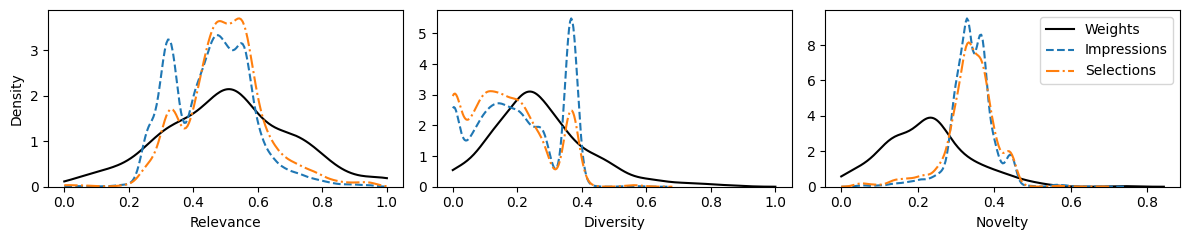

In [243]:
fig, ax = plt.subplots(1,3, figsize=(12,2.5))

sns.kdeplot(dfGroupedWeights, x="relevanceWeight", color=(0,0,0), clip=(0,1), label="Weights", ax=ax[0])
sns.kdeplot(dfShownNormImpressions, x="relevanceGain",  common_norm=False, clip=(0,1), linestyle="--", label="Impressions", ax=ax[0]) #hue="algorithm",
sns.kdeplot(dfShownNormSelections, x="relevanceGain",  common_norm=False, linestyle="-.", clip=(0,1), label="Selections", ax=ax[0])


sns.kdeplot(dfGroupedWeights, x="diversityWeight", color=(0,0,0), clip=(0,1), label="Weights", ax=ax[1])
sns.kdeplot(dfShownNormImpressions, x="diversityGain",  common_norm=False, clip=(0,1), linestyle="--", label="Impressions", ax=ax[1]) #hue="algorithm",
sns.kdeplot(dfShownNormSelections, x="diversityGain",  common_norm=False, linestyle="-.", clip=(0,1), label="Selections", ax=ax[1])


sns.kdeplot(dfGroupedWeights, x="noveltyWeight", color=(0,0,0), clip=(0,1), label="Weights", ax=ax[2])
sns.kdeplot(dfShownNormImpressions, x="noveltyGain",  common_norm=False, clip=(0,1), linestyle="--", label="Impressions", ax=ax[2]) #hue="algorithm",
sns.kdeplot(dfShownNormSelections, x="noveltyGain",  common_norm=False, linestyle="-.", clip=(0,1), label="Selections", ax=ax[2])

ax[2].legend()
ax[0].set_xlabel("Relevance")
ax[1].set_xlabel("Diversity")
ax[1].set_ylabel("")
ax[2].set_xlabel("Novelty")
ax[2].set_ylabel("")
plt.tight_layout()
plt.savefig("./results/weights_impressions_selections_distrib.pdf")